### Import Data from Feature Selection Methods

In [1]:
import pandas as pd

# Load the results file
file_path = "b4_combined_results.csv"
results_df = pd.read_csv(file_path)

### Use Scoring Formula to determine top 5 performing models and feature selection methods

In [6]:
# Define weights for the selection formula
alpha = 0.5  # Precision weight
beta = 0.3   # Recall weight
gamma = 0.05  # Balanced accuracy 
delta = 0.05  # MCC
epsilon = 0.05  # F1-score
zeta = 0.05  # PR-AUC_0

# Convert relevant columns to float
for metric in ["Precision", "Recall", "Balanced Accuracy", "MCC", "F1 Score", "PR-AUC_0"]:
    results_df[metric] = results_df[metric].astype(float)

# Compute the updated selection score
results_df["Score"] = (
    alpha * results_df["Precision"] +
    beta * results_df["Recall"] +
    gamma * results_df["Balanced Accuracy"] +
    delta * results_df["MCC"] +
    epsilon * results_df["F1 Score"] +
    zeta * results_df["PR-AUC_0"]
)

# Select the model with the highest score
best_model = results_df.loc[results_df["Score"].idxmax()]

# Print the best model and feature selection method
print("Best Model for Fake Review Detection (Using Scoring Formula):")
print(best_model[["Model", "Precision", "Recall", "Balanced Accuracy", "MCC", "F1 Score", "PR-AUC_0", "Score"]])

# Sort models and select the top 5
top_5_models = results_df.sort_values(by="Score", ascending=False).head(5)

print(top_5_models[["Model", "Precision", "Recall", "Balanced Accuracy", "MCC", "F1 Score", "PR-AUC_0", "Score"]])


Best Model for Fake Review Detection (Using Scoring Formula):
Model                RF_MI_FMS
Precision               0.2318
Recall                  0.9614
Balanced Accuracy        0.738
MCC                      0.324
F1 Score                0.3735
PR-AUC_0                0.0838
Score                 0.480285
Name: 34, dtype: object
               Model  Precision  Recall  Balanced Accuracy     MCC  F1 Score  \
34         RF_MI_FMS     0.2318  0.9614             0.7380  0.3240    0.3735   
26         RF_MI_FSS     0.2318  0.9611             0.7379  0.3239    0.3735   
50   RF_Lasso_MI_FMS     0.2320  0.9603             0.7380  0.3238    0.3737   
42   RF_Lasso_MI_FSS     0.2323  0.9401             0.7334  0.3173    0.3725   
44  XGB_Lasso_MI_FSS     0.2264  0.9358             0.7243  0.3052    0.3646   

    PR-AUC_0     Score  
34    0.0838  0.480285  
26    0.0839  0.480190  
50    0.0841  0.480070  
42    0.0836  0.473520  
44    0.0801  0.467650  


### Import Libraries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, precision_recall_curve, auc

### Load Dataset

In [7]:
df = pd.read_csv('../00_dataset/YelpZip/metadata', 
                 sep='\t',
                 header=None,
                 names=["user_id", "prod_id", "rating", "label", "date"])
reviews_df = pd.read_csv('../00_dataset/YelpZip/reviewContent',
                sep='\t',
                header=None,
                names=['user_id', 'prod_id', 'date', 'review'])

df = df.merge(reviews_df,
              left_on=['user_id', 'prod_id', 'date'],
              right_on=['user_id', 'prod_id', 'date'],
              how='left')
df = df.dropna(subset=['review'])
df

,user_id,prod_id,rating,label,date,review
0,5044,0,1.0,-1,2014-11-16,"Drinks were bad, the hot chocolate was watered..."
1,5045,0,1.0,-1,2014-09-08,This was the worst experience I've ever had a ...
2,5046,0,3.0,-1,2013-10-06,This is located on the site of the old Spruce ...
3,5047,0,5.0,-1,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...
4,5048,0,5.0,-1,2014-08-28,I love Toast! The food choices are fantastic -...
...,...,...,...,...,...,...
608593,119664,5039,4.0,1,2013-01-20,When I first moved to the area I must say I wa...
608594,56277,5039,2.0,1,2012-11-12,Kind of pricey. I guess I expected a ridiculou...
608595,265320,5039,1.0,1,2012-08-22,"Stopped by this restaurant yesterday, we just ..."
608596,161722,5039,4.0,1,2011-05-11,Finally checked out The Best Subs in Claremont...


### Set correct labels, and split training and test set

In [8]:
df['label'] = df['label'].replace({1: 0, -1: 1})
y = df['label']
X = df.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=y_train)

In [9]:
print(f"""
X_train: {X_train.shape}
X_validation: {X_val.shape}
X_test: {X_test.shape}
y_train: {y_train.shape}
y_validation: {y_val.shape}
y_test: {y_test.shape}
""")


X_train: (425920, 5)
X_validation: (60846, 5)
X_test: (121692, 5)
y_train: (425920,)
y_validation: (60846,)
y_test: (121692,)



### Select Model

In [10]:
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier

chosen_model = RandomForestClassifier()

### Select Features (RF_MI_FMS was the best performing, hence MI selected features are used)

In [11]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from FeatureEngineer import CombinedEngineer
from SmoteTransformer import SMOTETransformer

pipeline = Pipeline([
    ('feature_engineering', CombinedEngineer(drop_columns=['rating_max', 'median_rating_for_restaurant', 'rating', 'users_avg_per_day', 'user_restaurants_reviewed', 'user_review_timespan', 'rating_std', 'rating_mean', 'user_active_percentage', 'user_days_active'])),  # Feature engineering
    ('scaler', MinMaxScaler()),  # scaling
    ('smote', SMOTETransformer(sampling_strategy='auto', random_state=42)),  # SMOTE
    ('classifier', chosen_model)  # Classifier
])

In [12]:
# Fit model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_engineering',
                 <FeatureEngineer.CombinedEngineer object at 0x000001EE0000B5C0>),
                ('scaler', MinMaxScaler()),
                ('smote',
                 <SmoteTransformer.SMOTETransformer object at 0x000001EE020B2420>),
                ('classifier', RandomForestClassifier())])

In [21]:
# Evaluate model
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

In [22]:
# Get results and convert to DataFrame
df_probs = pd.DataFrame(y_pred_proba, columns=[f"Prob (Class {i})" for i in range(y_pred_proba.shape[1])])

# Add actual labels and predictions to the DataFrame
df_probs['Actual Label'] = y_test.values
df_probs['Predicted Label'] = y_pred

In [ ]:
df_probs.to_csv("b5_model_probabilities_RF_MI_FMS.csv")

In [7]:
# Display the top models as a DataFrame
df_summary = top_5_models[["Model", "Precision", "Recall", "F1 Score", "MCC", "Balanced Accuracy", "PR-AUC_0", "Score"]]
df_summary = df_summary.sort_values(by="Score", ascending=False)  # Sort by selection score

# Display the table
df_summary


,Model,Precision,Recall,F1 Score,MCC,Balanced Accuracy,PR-AUC_0,Score
34,RF_MI_FMS,0.2318,0.9614,0.3735,0.3240,0.7380,0.0838,0.480285
26,RF_MI_FSS,0.2318,0.9611,0.3735,0.3239,0.7379,0.0839,0.480190
50,RF_Lasso_MI_FMS,0.2320,0.9603,0.3737,0.3238,0.7380,0.0841,0.480070
42,RF_Lasso_MI_FSS,0.2323,0.9401,0.3725,0.3173,0.7334,0.0836,0.473520
44,XGB_Lasso_MI_FSS,0.2264,0.9358,0.3646,0.3052,0.7243,0.0801,0.467650


### Load data for visualisation

In [3]:
# Load the test dataset predictions for RF_MI_FMS and RF_SS
rf_mi_fms_path = "b5_model_probabilities_RF_MI_FMS.csv"
rf_ss_path = "b5_model_probabilities_RF_SS.csv"

# Read the CSV files
rf_mi_fms_df = pd.read_csv(rf_mi_fms_path)
rf_ss_df = pd.read_csv(rf_ss_path)

# Display the first few rows to check the structure
rf_mi_fms_df.head(), rf_ss_df.head()


C:\Users\imman\AppData\Local\Temp\ipykernel_30268\1025263230.py:6: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  rf_mi_fms_df = pd.read_csv(rf_mi_fms_path)


(   Actual Label  Predicted Label  Prob (Class 0 - Not Spam)  \
 0             0                0                   0.988861   
 1             0                1                   0.287002   
 2             1                1                   0.365537   
 3             0                0                   0.786592   
 4             0                0                   0.987055   
 
    Prob (Class 1 - Spam)  Unnamed: 4  Unnamed: 5  Unnamed: 6  Unnamed: 7  \
 0               0.011139         NaN         NaN         NaN         NaN   
 1               0.712998         NaN         NaN         NaN         NaN   
 2               0.634463         NaN         NaN         NaN         NaN   
 3               0.213408         NaN         NaN         NaN         NaN   
 4               0.012945         NaN         NaN         NaN         NaN   
 
    Unnamed: 8 Unnamed: 9  
 0         NaN        NaN  
 1         NaN        NaN  
 2         NaN        NaN  
 3         NaN        NaN  
 4        

### Plot Bar Chart and Confusion Matrix for RF_MI_FMS and RF_SS

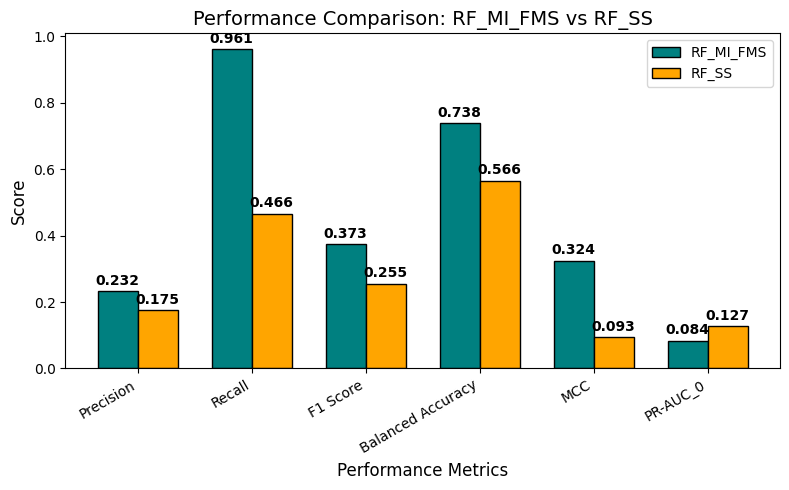

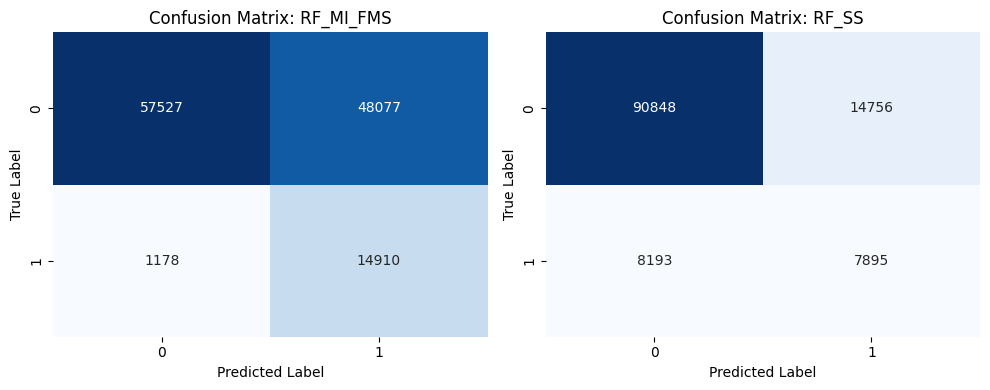

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

# Extract RF_MI_FMS and RF_SS models from the dataset
rf_mi_fms = results_df[results_df["Model"] == "RF_MI_FMS"].iloc[0]
rf_ss = results_df[results_df["Model"] == "RF_SS"].iloc[0]

# Extract columns from both datasets
y_true = rf_mi_fms_df["Actual Label"]  # True labels 
y_pred_rf_mi_fms = rf_mi_fms_df["Predicted Label"]  # Predictions for RF_MI_FMS
y_pred_rf_ss = rf_ss_df["Predicted Label"]  # Predictions for RF_SS


# Bar Chart (Final Model vs. Baseline)
def plot_metric_comparison(model1, model2, model1_name, model2_name):
    metrics = ["Precision", "Recall", "F1 Score", "Balanced Accuracy", "MCC", "PR-AUC_0"]
    model1_scores = [model1[m] for m in metrics]
    model2_scores = [model2[m] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width/2, model1_scores, width, label=model1_name, color="teal", edgecolor="black")
    ax.bar(x + width/2, model2_scores, width, label=model2_name, color="orange", edgecolor="black")

    # Labels and formatting
    ax.set_xlabel("Performance Metrics", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    ax.set_title(f"Performance Comparison: {model1_name} vs {model2_name}", fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=30, ha='right')
    ax.legend()

    # Show values on top of bars
    for i in range(len(metrics)):
        ax.text(i - width/2, model1_scores[i] + 0.02, f"{model1_scores[i]:.3f}", ha='center', fontsize=10, fontweight='bold')
        ax.text(i + width/2, model2_scores[i] + 0.02, f"{model2_scores[i]:.3f}", ha='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Confusion Matrix Comparison
def plot_confusion_matrices(y_true, y_pred_model1, y_pred_model2, model1_name, model2_name):
    cm1 = confusion_matrix(y_true, y_pred_model1)
    cm2 = confusion_matrix(y_true, y_pred_model2)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    for ax, cm, title in zip(axes, [cm1, cm2], [model1_name, model2_name]):
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False, ax=ax)
        ax.set_title(f"Confusion Matrix: {title}")
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")

    plt.tight_layout()
    plt.show()



# Generate visualisations
plot_metric_comparison(rf_mi_fms, rf_ss, "RF_MI_FMS", "RF_SS")
plot_confusion_matrices(y_true, y_pred_rf_mi_fms, y_pred_rf_ss, "RF_MI_FMS", "RF_SS")
